# Person-Scene Integration with Shadow and Lighting Analysis

This notebook implements a comprehensive algorithm to seamlessly integrate a person with shadow into a background scene, considering lighting conditions and shadows.

## Setup and Installation
Run this cell to install required packages in Google Colab

In [1]:
# Install required packages
!pip install opencv-python-headless numpy matplotlib scikit-image scipy rembg pillow
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 529.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124


## Import Required Libraries

In [2]:
!pip install onnxruntime rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from rembg import remove
from scipy import ndimage
from scipy.spatial import distance
from scipy.interpolate import interp1d
from skimage import exposure, color, morphology, filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import warnings
warnings.filterwarnings('ignore')

# For Google Colab file upload
from google.colab import files
import io

## Utility Functions

In [4]:
def upload_image(prompt="Upload an image"):
    """Upload image in Google Colab"""
    print(prompt)
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[filename]))
    return np.array(image)

def display_image(img, title="Image", figsize=(10, 8)):
    """Display image with title"""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_multiple_images(images, titles, cols=3, figsize=(15, 5)):
    """Display multiple images in a grid"""
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes

    for i, (img, title) in enumerate(zip(images, titles)):
        if i < len(axes):
            if len(img.shape) == 2:
                axes[i].imshow(img, cmap='gray')
            else:
                axes[i].imshow(img)
            axes[i].set_title(title)
            axes[i].axis('off')

    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Task 1: Capturing and Preparing the Person's Image

Upload the person image (with shadow)


Saving person_img.jpg to person_img.jpg


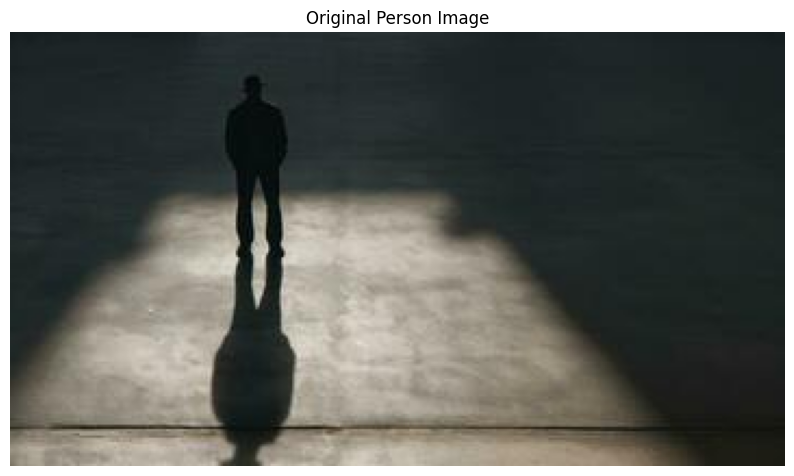

In [5]:
# Upload person image with shadow
person_img = upload_image("Upload the person image (with shadow)")
display_image(person_img, "Original Person Image")

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 165GB/s]


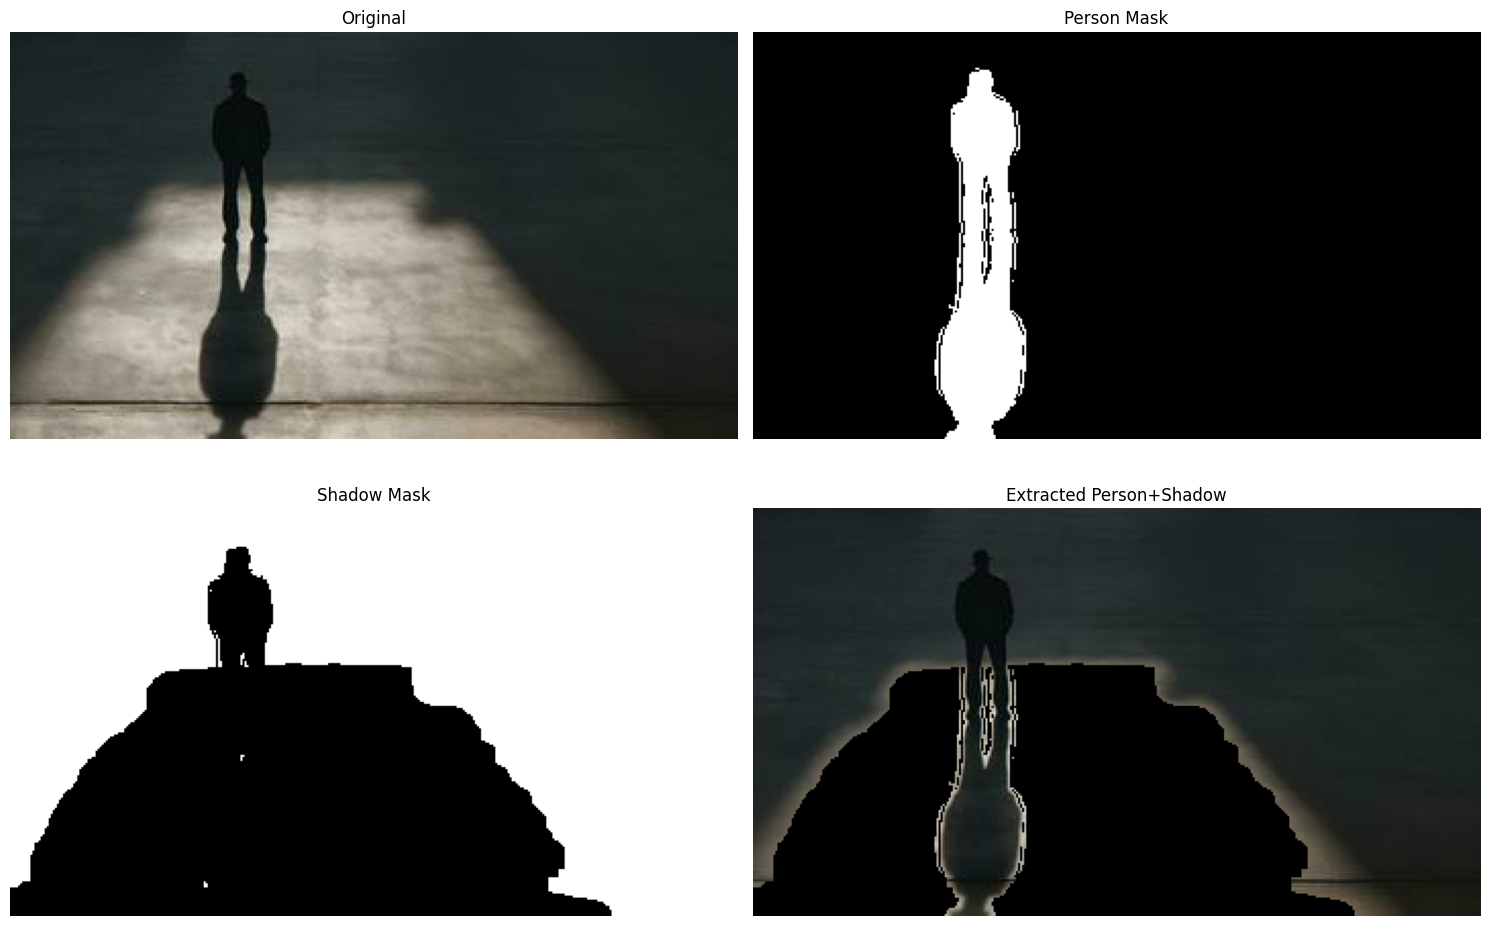

In [6]:
def extract_person_and_shadow(image):
    """
    Extract person and shadow from the image
    Returns: person_mask, shadow_mask, person_with_shadow
    """
    # Convert to RGB if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Remove background using rembg to get person mask
    person_removed_bg = remove(image)

    # Create person mask
    person_mask = person_removed_bg[:,:,3] > 0 if person_removed_bg.shape[2] == 4 else np.ones_like(image[:,:,0])

    # Convert to grayscale for shadow detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Shadow detection using multiple techniques
    # 1. Threshold-based shadow detection
    _, shadow_thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    # 2. Morphological operations to clean up
    kernel = np.ones((5,5), np.uint8)
    shadow_cleaned = cv2.morphologyEx(shadow_thresh, cv2.MORPH_CLOSE, kernel)
    shadow_cleaned = cv2.morphologyEx(shadow_cleaned, cv2.MORPH_OPEN, kernel)

    # 3. Remove person region from shadow mask
    shadow_mask = shadow_cleaned.copy()
    shadow_mask[person_mask > 0] = 0

    # 4. Keep only connected components near the person
    # Find contours
    contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Keep only shadow regions connected or near to person
    final_shadow_mask = np.zeros_like(shadow_mask)
    person_dilated = cv2.dilate(person_mask.astype(np.uint8), kernel, iterations=3)

    for contour in contours:
        mask_temp = np.zeros_like(shadow_mask)
        cv2.drawContours(mask_temp, [contour], -1, 255, -1)

        # Check if shadow touches dilated person
        if np.any(mask_temp & person_dilated):
            final_shadow_mask |= mask_temp

    # Create combined mask
    combined_mask = (person_mask > 0) | (final_shadow_mask > 0)

    # Extract person with shadow
    person_with_shadow = image.copy()
    person_with_shadow[~combined_mask] = 0

    # Add alpha channel
    alpha = combined_mask.astype(np.uint8) * 255
    person_with_shadow = np.dstack([person_with_shadow, alpha])

    return person_mask.astype(np.uint8) * 255, final_shadow_mask, person_with_shadow

# Extract person and shadow
person_mask, shadow_mask, person_with_shadow = extract_person_and_shadow(person_img)

# Display results
display_multiple_images(
    [person_img, person_mask, shadow_mask, person_with_shadow[:,:,:3]],
    ["Original", "Person Mask", "Shadow Mask", "Extracted Person+Shadow"],
    cols=2
)

## Task 2: Analyzing Shadows and Lighting of the Background Image

Upload the background/scene image


Saving bg_img.jpg to bg_img.jpg


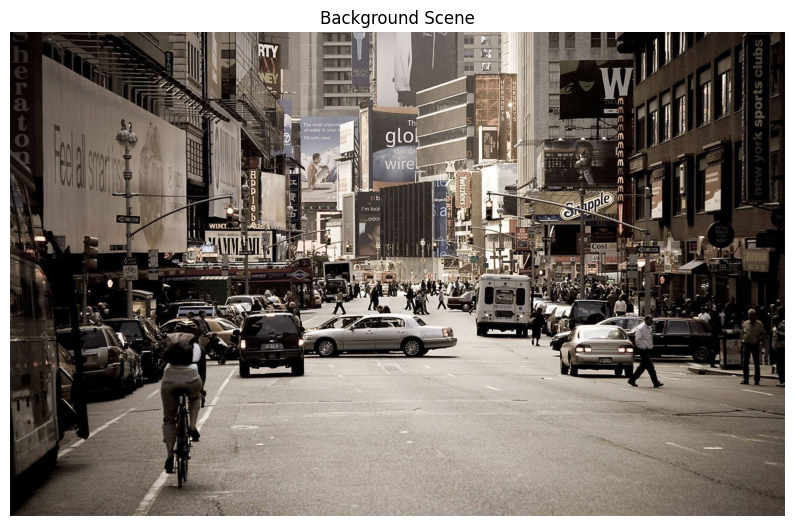

In [7]:
# Upload background image
bg_img = upload_image("Upload the background/scene image")
display_image(bg_img, "Background Scene")

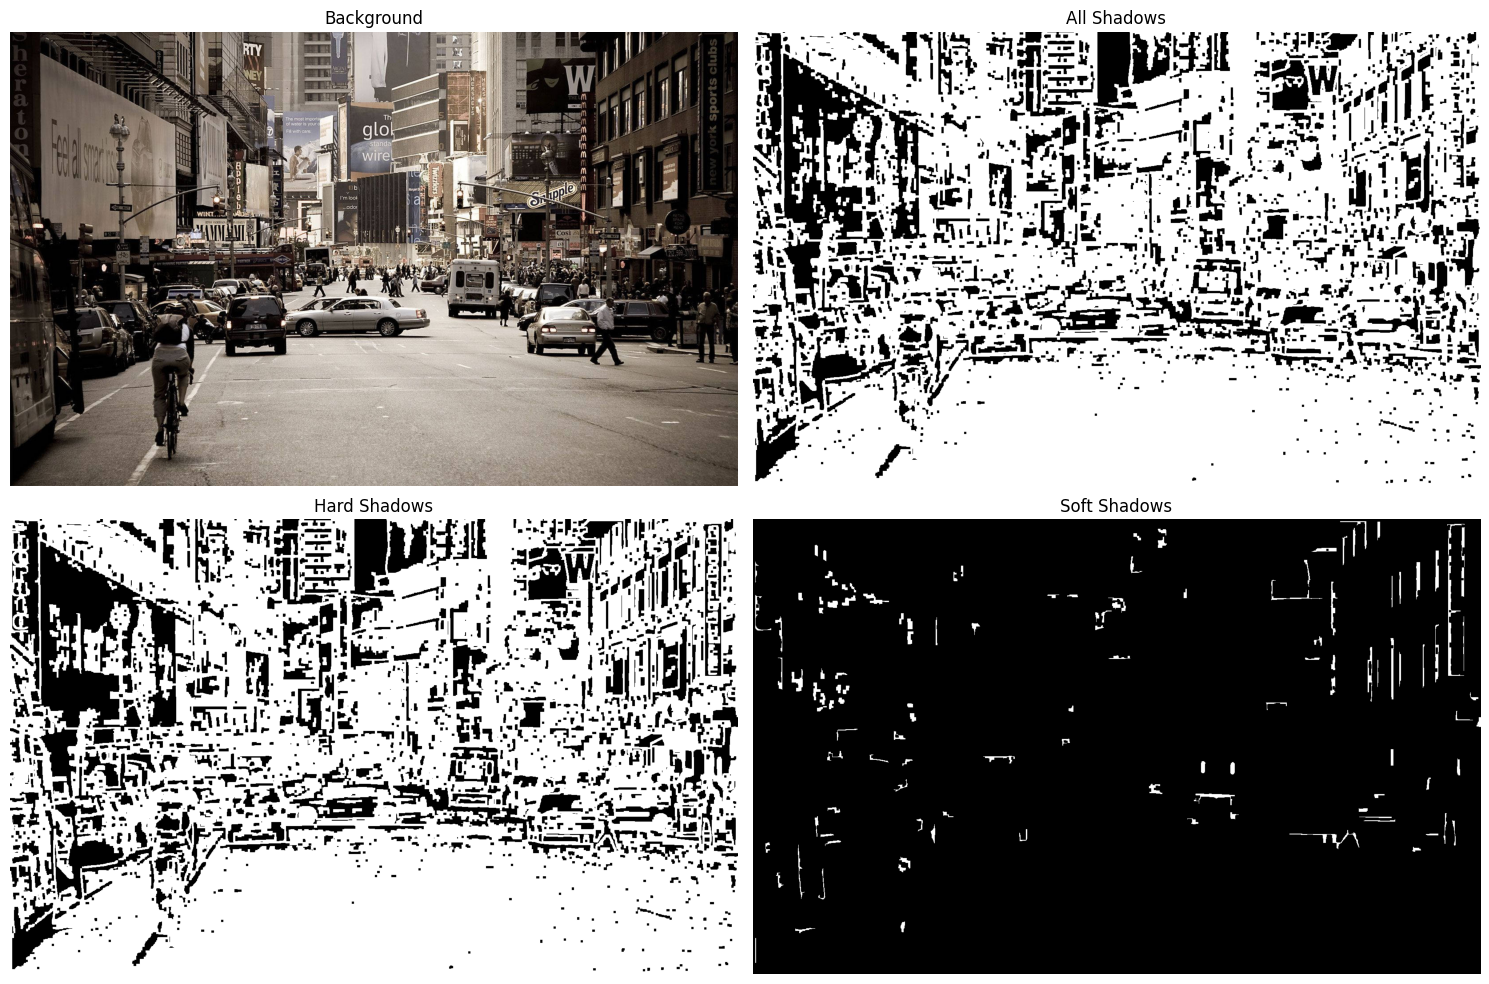

In [8]:
def detect_and_classify_shadows(image):
    """
    Detect and classify shadows in the background image
    Returns: all_shadows_mask, hard_shadows_mask, soft_shadows_mask
    """
    # Convert to LAB color space for better shadow detection
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel = lab[:,:,0]

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l_channel)

    # Shadow detection using adaptive thresholding
    shadow_map = cv2.adaptiveThreshold(l_enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 21, 5)

    # Morphological operations
    kernel = np.ones((5,5), np.uint8)
    shadow_map = cv2.morphologyEx(shadow_map, cv2.MORPH_CLOSE, kernel)
    shadow_map = cv2.morphologyEx(shadow_map, cv2.MORPH_OPEN, kernel)

    # Detect edges for hard shadow classification
    edges = cv2.Canny(l_enhanced, 50, 150)
    edges_dilated = cv2.dilate(edges, kernel, iterations=2)

    # Classify shadows
    hard_shadows = shadow_map & edges_dilated
    soft_shadows = shadow_map & (~edges_dilated)

    # Clean up small regions
    hard_shadows = morphology.remove_small_objects(hard_shadows.astype(bool), min_size=100)
    soft_shadows = morphology.remove_small_objects(soft_shadows.astype(bool), min_size=100)

    all_shadows = hard_shadows | soft_shadows

    return all_shadows.astype(np.uint8) * 255, hard_shadows.astype(np.uint8) * 255, soft_shadows.astype(np.uint8) * 255

# Detect and classify shadows
all_shadows, hard_shadows, soft_shadows = detect_and_classify_shadows(bg_img)

# Display results
display_multiple_images(
    [bg_img, all_shadows, hard_shadows, soft_shadows],
    ["Background", "All Shadows", "Hard Shadows", "Soft Shadows"],
    cols=2
)

## Task 3: Determining Light Direction

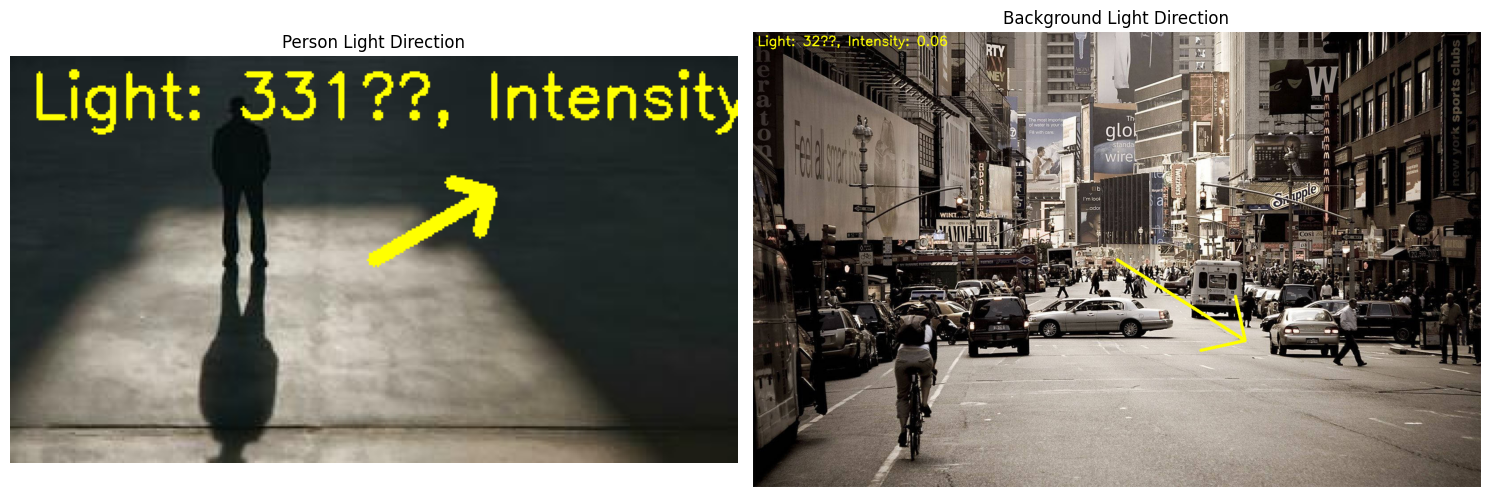

Person light: 331° @ 0.38 intensity
Background light: 32° @ 0.06 intensity


In [9]:
def estimate_light_direction(image, shadow_mask):
    """
    Estimate light direction from shadows in the image
    Returns: angle (in degrees), intensity, visualization
    """
    h, w = image.shape[:2]

    # Find shadow contours
    contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        # No shadows found, estimate from image brightness
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Divide image into quadrants
        quadrants = [
            gray[:h//2, :w//2],      # Top-left
            gray[:h//2, w//2:],      # Top-right
            gray[h//2:, :w//2],      # Bottom-left
            gray[h//2:, w//2:]       # Bottom-right
        ]

        # Calculate average brightness
        brightness = [np.mean(q) for q in quadrants]

        # Estimate light direction from brightest quadrant
        brightest = np.argmax(brightness)
        angles = [135, 45, 225, 315]  # Angles for each quadrant
        angle = angles[brightest]
        intensity = max(brightness) / 255.0
    else:
        # Analyze shadow directions
        shadow_vectors = []

        for contour in contours:
            if cv2.contourArea(contour) < 100:  # Skip small shadows
                continue

            # Get contour moments
            M = cv2.moments(contour)
            if M["m00"] == 0:
                continue

            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Find the farthest point from centroid
            distances = [np.sqrt((p[0][0]-cx)**2 + (p[0][1]-cy)**2) for p in contour]
            farthest_idx = np.argmax(distances)
            farthest_point = contour[farthest_idx][0]

            # Calculate shadow vector
            shadow_vector = (farthest_point[0] - cx, farthest_point[1] - cy)
            shadow_vectors.append(shadow_vector)

        if shadow_vectors:
            # Average shadow direction
            avg_vector = np.mean(shadow_vectors, axis=0)
            angle = np.degrees(np.arctan2(-avg_vector[1], -avg_vector[0])) % 360

            # Estimate intensity from shadow darkness
            shadow_region = image[shadow_mask > 0]
            non_shadow_region = image[shadow_mask == 0]

            if len(shadow_region) > 0 and len(non_shadow_region) > 0:
                shadow_brightness = np.mean(cv2.cvtColor(shadow_region.reshape(-1, 1, 3), cv2.COLOR_RGB2GRAY))
                non_shadow_brightness = np.mean(cv2.cvtColor(non_shadow_region.reshape(-1, 1, 3), cv2.COLOR_RGB2GRAY))
                intensity = (non_shadow_brightness - shadow_brightness) / 255.0
            else:
                intensity = 0.5
        else:
            angle = 45  # Default angle
            intensity = 0.5

    # Create visualization
    viz = image.copy()
    center = (w//2, h//2)
    length = min(w, h) // 3
    end_x = int(center[0] + length * np.cos(np.radians(angle)))
    end_y = int(center[1] + length * np.sin(np.radians(angle)))

    # Draw light direction arrow
    cv2.arrowedLine(viz, center, (end_x, end_y), (255, 255, 0), 5, tipLength=0.3)
    cv2.putText(viz, f"Light: {angle:.0f}°, Intensity: {intensity:.2f}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    return angle, intensity, viz

# Estimate light direction for both images
bg_light_angle, bg_light_intensity, bg_light_viz = estimate_light_direction(bg_img, all_shadows)
person_light_angle, person_light_intensity, person_light_viz = estimate_light_direction(person_img, shadow_mask)

display_multiple_images(
    [person_light_viz, bg_light_viz],
    ["Person Light Direction", "Background Light Direction"],
    cols=2
)

print(f"Person light: {person_light_angle:.0f}° @ {person_light_intensity:.2f} intensity")
print(f"Background light: {bg_light_angle:.0f}° @ {bg_light_intensity:.2f} intensity")

## Task 4: Coloring and Blending - Color Matching Algorithm

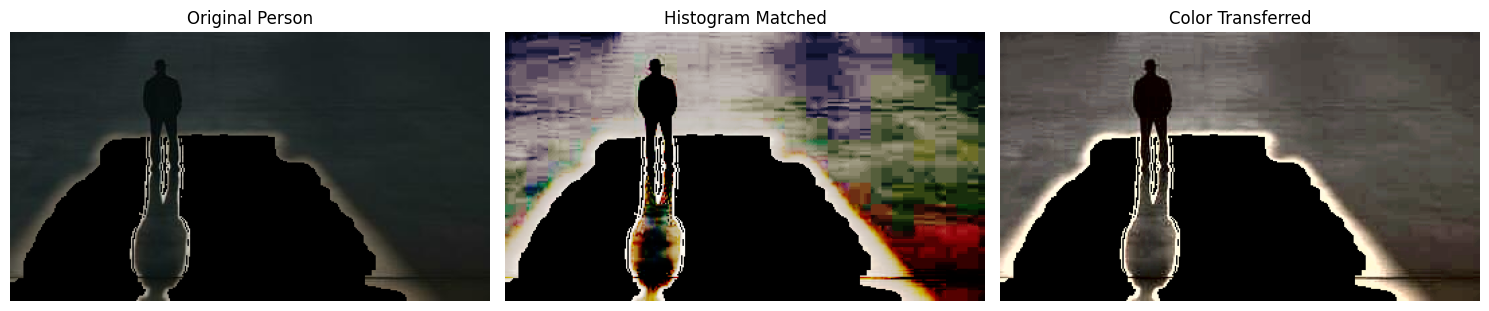

In [10]:
def analyze_color_statistics(image, mask=None):
    """
    Analyze color statistics of an image
    """
    if mask is not None:
        pixels = image[mask > 0]
    else:
        pixels = image.reshape(-1, 3)

    if len(pixels) == 0:
        return None

    # Convert to LAB for better color analysis
    lab_pixels = cv2.cvtColor(pixels.reshape(-1, 1, 3), cv2.COLOR_RGB2LAB).reshape(-1, 3)

    stats = {
        'mean_rgb': np.mean(pixels, axis=0),
        'std_rgb': np.std(pixels, axis=0),
        'mean_lab': np.mean(lab_pixels, axis=0),
        'std_lab': np.std(lab_pixels, axis=0)
    }

    return stats

def histogram_matching(source, reference, mask=None):
    """
    Match histogram of source image to reference
    """
    matched = np.zeros_like(source)

    for i in range(3):
        # Get channel
        src_channel = source[:,:,i]
        ref_channel = reference[:,:,i]

        # Calculate histograms
        if mask is not None:
            src_hist, _ = np.histogram(src_channel[mask > 0], bins=256, range=[0,256])
        else:
            src_hist, _ = np.histogram(src_channel.flatten(), bins=256, range=[0,256])

        ref_hist, _ = np.histogram(ref_channel.flatten(), bins=256, range=[0,256])

        # Calculate CDFs
        src_cdf = src_hist.cumsum()
        src_cdf = src_cdf / float(src_cdf[-1])

        ref_cdf = ref_hist.cumsum()
        ref_cdf = ref_cdf / float(ref_cdf[-1])

        # Create lookup table
        lookup = np.zeros(256, dtype=np.uint8)
        for j in range(256):
            idx = np.argmin(np.abs(ref_cdf - src_cdf[j]))
            lookup[j] = idx

        # Apply lookup
        matched[:,:,i] = lookup[src_channel]

    return matched

def color_transfer(source, target, mask=None, preserve_paper=True):
    """
    Transfer color characteristics from target to source
    Based on "Color Transfer between Images" by Reinhard et al.
    """
    # Convert to LAB
    source_lab = cv2.cvtColor(source, cv2.COLOR_RGB2LAB).astype(float)
    target_lab = cv2.cvtColor(target, cv2.COLOR_RGB2LAB).astype(float)

    # Get statistics
    if mask is not None:
        source_mean = np.array([np.mean(source_lab[mask > 0, i]) for i in range(3)])
        source_std = np.array([np.std(source_lab[mask > 0, i]) for i in range(3)])
    else:
        source_mean = np.array([np.mean(source_lab[:,:,i]) for i in range(3)])
        source_std = np.array([np.std(source_lab[:,:,i]) for i in range(3)])

    target_mean = np.array([np.mean(target_lab[:,:,i]) for i in range(3)])
    target_std = np.array([np.std(target_lab[:,:,i]) for i in range(3)])

    # Transfer
    result_lab = source_lab.copy()

    for i in range(3):
        result_lab[:,:,i] = (result_lab[:,:,i] - source_mean[i]) * (target_std[i] / source_std[i]) + target_mean[i]

    # Convert back to RGB
    result_lab = np.clip(result_lab, 0, 255).astype(np.uint8)
    result = cv2.cvtColor(result_lab, cv2.COLOR_LAB2RGB)

    # Apply only to masked region if mask provided
    if mask is not None:
        final_result = source.copy()
        final_result[mask > 0] = result[mask > 0]
        return final_result

    return result

# Perform color matching
person_matched_hist = histogram_matching(person_with_shadow[:,:,:3], bg_img,
                                        mask=(person_with_shadow[:,:,3] > 0).astype(np.uint8))
person_matched_color = color_transfer(person_with_shadow[:,:,:3], bg_img,
                                     mask=(person_with_shadow[:,:,3] > 0).astype(np.uint8))

# Display results
display_multiple_images(
    [person_with_shadow[:,:,:3], person_matched_hist, person_matched_color],
    ["Original Person", "Histogram Matched", "Color Transferred"],
    cols=3
)

## Shadow Transformation and Adjustment

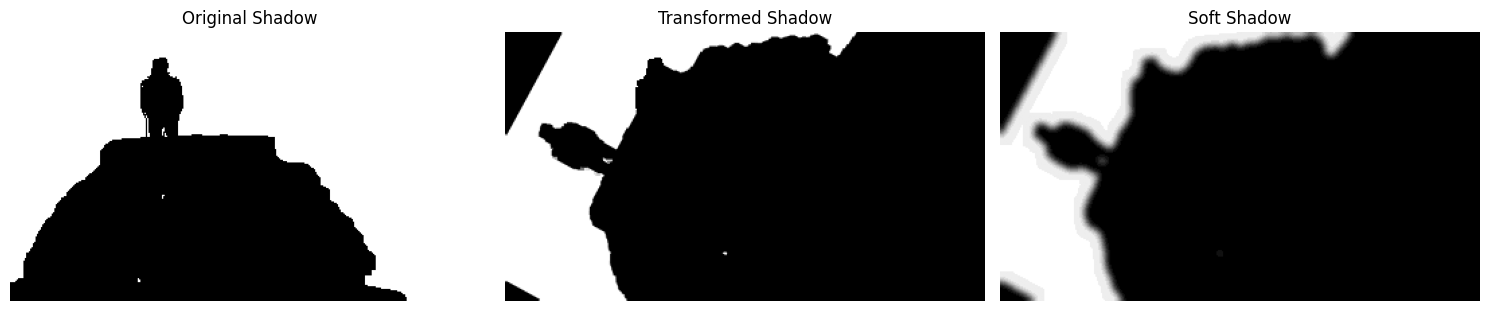

In [11]:
def transform_shadow(shadow_mask, person_mask, source_angle, target_angle, target_intensity):
    """
    Transform shadow based on light direction change
    """
    h, w = shadow_mask.shape

    # Calculate angle difference
    angle_diff = target_angle - source_angle

    # Find person centroid
    person_points = np.column_stack(np.where(person_mask > 0))
    if len(person_points) == 0:
        return shadow_mask

    person_center = np.mean(person_points, axis=0)

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((person_center[1], person_center[0]), angle_diff, 1.0)

    # Transform shadow
    transformed_shadow = cv2.warpAffine(shadow_mask, rotation_matrix, (w, h))

    # Adjust shadow intensity
    transformed_shadow = (transformed_shadow * target_intensity).astype(np.uint8)

    # Ensure shadow doesn't overlap with person
    transformed_shadow[person_mask > 0] = 0

    # Apply morphological operations for smoothing
    kernel = np.ones((3,3), np.uint8)
    transformed_shadow = cv2.morphologyEx(transformed_shadow, cv2.MORPH_CLOSE, kernel)

    return transformed_shadow

def create_soft_shadow(shadow_mask, blur_size=15):
    """
    Create soft shadow effect
    """
    # Apply Gaussian blur for soft edges
    soft_shadow = cv2.GaussianBlur(shadow_mask.astype(float), (blur_size, blur_size), 0)

    # Normalize
    soft_shadow = np.clip(soft_shadow, 0, 255).astype(np.uint8)

    return soft_shadow

# Transform shadow to match background lighting
transformed_shadow = transform_shadow(shadow_mask, person_mask,
                                    person_light_angle, bg_light_angle,
                                    bg_light_intensity)

# Create soft shadow version
soft_shadow = create_soft_shadow(transformed_shadow)

# Display shadow transformations
display_multiple_images(
    [shadow_mask, transformed_shadow, soft_shadow],
    ["Original Shadow", "Transformed Shadow", "Soft Shadow"],
    cols=3
)

## Task 5: Generating the Final Output

## Interactive Adjustment Cell
### Adjust these parameters and re-run the cell below to fine-tune the result

In [12]:
# INTERACTIVE PARAMETERS - Adjust these values and re-run this cell
# ================================================================

# Size adjustment
SCALE_MULTIPLIER = 1.0      # Make person larger (>1) or smaller (<1)
                           # Try values like 0.5, 0.8, 1.2, 1.5

HEIGHT_RATIO = 0.4         # Person height as ratio of background height
                          # 0.3 = 30% of background height
                          # 0.5 = 50% of background height
                          # 0.7 = 70% of background height

# Position adjustment
X_POSITION_RATIO = 0.5     # Horizontal position
                          # 0.0 = far left
                          # 0.5 = center
                          # 1.0 = far right

Y_POSITION_RATIO = 0.7     # Vertical position
                          # 0.3 = upper part
                          # 0.5 = middle
                          # 0.7 = lower part (ground level)

# Shadow intensity
SHADOW_OPACITY = 0.5       # Shadow darkness (0 = invisible, 1 = black)

# Edge blending
FEATHER_AMOUNT = 3         # Edge softness (1-10, higher = softer edges)

print("Parameters set:")
print(f"Scale multiplier: {SCALE_MULTIPLIER}")
print(f"Height ratio: {HEIGHT_RATIO}")
print(f"Position: ({X_POSITION_RATIO}, {Y_POSITION_RATIO})")
print(f"Shadow opacity: {SHADOW_OPACITY}")
print(f"Feather amount: {FEATHER_AMOUNT}")

Parameters set:
Scale multiplier: 1.0
Height ratio: 0.4
Position: (0.5, 0.7)
Shadow opacity: 0.5
Feather amount: 3


Scale: 2.05, Position: (819, 716)
Person will be 410 pixels tall
Background is 1024 pixels tall
Person is 40% of background height


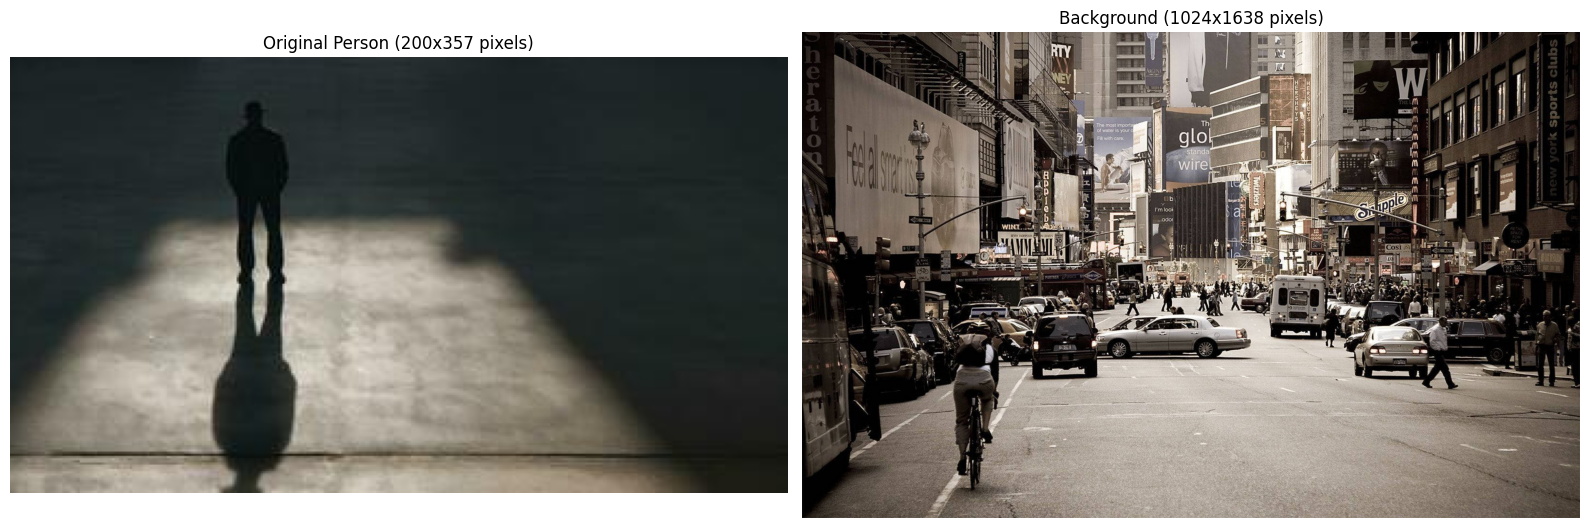

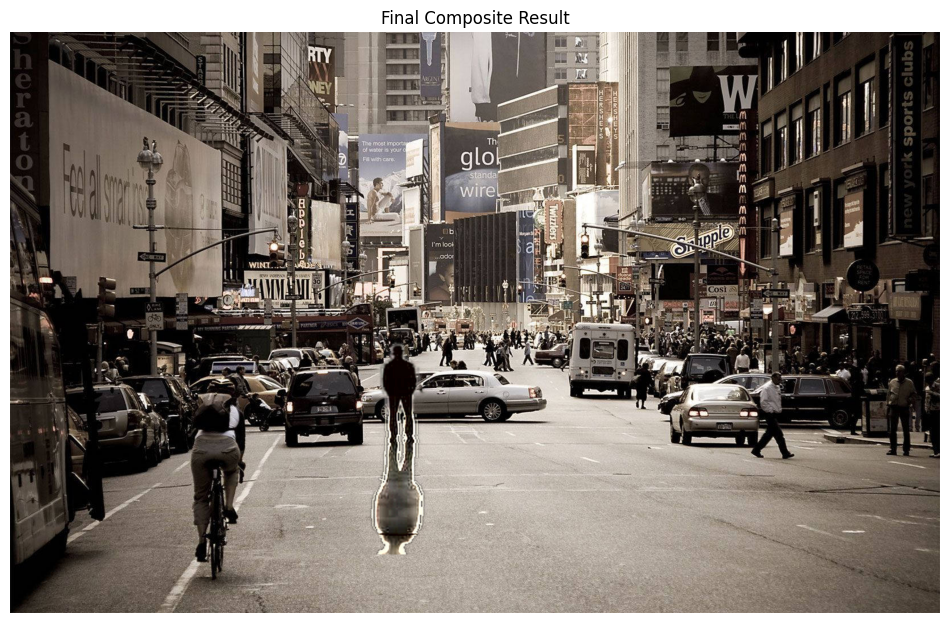

In [13]:
def find_optimal_placement(person_img, bg_img, target_height_ratio=0.4):
    """
    Find optimal placement for person in scene
    target_height_ratio: person height as ratio of background height (default 0.4 = 40%)
    """
    h_bg, w_bg = bg_img.shape[:2]
    h_p, w_p = person_img.shape[:2]

    # Calculate scale to make person height match target ratio of background
    target_height = h_bg * target_height_ratio
    best_scale = target_height / h_p

    # Ensure the width fits
    if w_p * best_scale > w_bg * 0.9:
        best_scale = (w_bg * 0.9) / w_p

    # Position in lower part of image (golden ratio)
    best_position = (w_bg // 2, int(h_bg * 0.7))

    return best_scale, best_position

def apply_lighting_adjustments(person_img, bg_img, mask):
    """
    Apply lighting adjustments to match scene
    """
    # Convert to LAB for lighting adjustments
    person_lab = cv2.cvtColor(person_img, cv2.COLOR_RGB2LAB).astype(float)
    bg_lab = cv2.cvtColor(bg_img, cv2.COLOR_RGB2LAB).astype(float)

    # Adjust luminance channel
    bg_luminance = np.mean(bg_lab[:,:,0])
    person_luminance = np.mean(person_lab[mask > 0, 0]) if np.any(mask > 0) else 128

    # Scale luminance
    luminance_scale = bg_luminance / person_luminance if person_luminance > 0 else 1.0
    luminance_scale = np.clip(luminance_scale, 0.5, 2.0)  # Limit adjustment range

    result_lab = person_lab.copy()
    result_lab[:,:,0] = result_lab[:,:,0] * luminance_scale

    # Convert back to RGB
    result_lab = np.clip(result_lab, 0, 255).astype(np.uint8)
    result = cv2.cvtColor(result_lab, cv2.COLOR_LAB2RGB)

    return result

def seamless_blend(foreground, background, mask, position, feather_amount=5):
    """
    Seamlessly blend foreground into background
    """
    h_fg, w_fg = foreground.shape[:2]
    h_bg, w_bg = background.shape[:2]

    # Create output image
    result = background.copy()

    # Calculate placement coordinates
    x_offset = position[0] - w_fg // 2
    y_offset = position[1] - h_fg // 2

    # Ensure coordinates are within bounds
    x_start = max(0, x_offset)
    y_start = max(0, y_offset)
    x_end = min(w_bg, x_offset + w_fg)
    y_end = min(h_bg, y_offset + h_fg)

    # Adjust foreground coordinates
    fg_x_start = max(0, -x_offset)
    fg_y_start = max(0, -y_offset)
    fg_x_end = fg_x_start + (x_end - x_start)
    fg_y_end = fg_y_start + (y_end - y_start)

    # Extract regions
    fg_region = foreground[fg_y_start:fg_y_end, fg_x_start:fg_x_end]
    mask_region = mask[fg_y_start:fg_y_end, fg_x_start:fg_x_end]

    # Feather the mask
    if feather_amount > 0:
        mask_float = mask_region.astype(float) / 255.0
        mask_feathered = cv2.GaussianBlur(mask_float, (feather_amount*2+1, feather_amount*2+1), 0)
    else:
        mask_feathered = mask_region.astype(float) / 255.0

    # Blend
    for c in range(3):
        result[y_start:y_end, x_start:x_end, c] = (
            fg_region[:,:,c] * mask_feathered +
            result[y_start:y_end, x_start:x_end, c] * (1 - mask_feathered)
        )

    return result

# Use parameters from the interactive cell above
# If parameters not defined, use defaults
try:
    scale_mult = SCALE_MULTIPLIER
    height_rat = HEIGHT_RATIO
    x_pos = X_POSITION_RATIO
    y_pos = Y_POSITION_RATIO
    shadow_op = SHADOW_OPACITY
    feather = FEATHER_AMOUNT
except:
    scale_mult = 1.0
    height_rat = 0.4
    x_pos = 0.5
    y_pos = 0.7
    shadow_op = 0.5
    feather = 3

# Find optimal placement with adjustable parameters
scale, position = find_optimal_placement(person_with_shadow, bg_img, height_rat)
scale *= scale_mult  # Apply manual scale adjustment

# Adjust position based on ratios
position = (int(bg_img.shape[1] * x_pos),
           int(bg_img.shape[0] * y_pos))

print(f"Scale: {scale:.2f}, Position: {position}")
print(f"Person will be {scale * person_with_shadow.shape[0]:.0f} pixels tall")
print(f"Background is {bg_img.shape[0]} pixels tall")
print(f"Person is {(scale * person_with_shadow.shape[0] / bg_img.shape[0] * 100):.0f}% of background height")

# Resize person and masks
new_size = (int(person_with_shadow.shape[1] * scale), int(person_with_shadow.shape[0] * scale))
person_resized = cv2.resize(person_matched_color, new_size, interpolation=cv2.INTER_LANCZOS4)
person_mask_resized = cv2.resize(person_mask, new_size, interpolation=cv2.INTER_LANCZOS4)
shadow_resized = cv2.resize(soft_shadow, new_size, interpolation=cv2.INTER_LANCZOS4)

# Apply lighting adjustments
person_lit = apply_lighting_adjustments(person_resized, bg_img, person_mask_resized)

# Create combined mask
combined_mask = np.maximum(person_mask_resized, shadow_resized)

# First blend shadow
shadow_color = np.zeros_like(person_resized)
shadow_alpha = shadow_resized.astype(float) / 255.0 * shadow_op  # Use adjustable shadow opacity

result_with_shadow = seamless_blend(shadow_color, bg_img,
                                   (shadow_alpha * 255).astype(np.uint8),
                                   position, feather_amount=10)

# Then blend person
final_result = seamless_blend(person_lit, result_with_shadow,
                             person_mask_resized, position, feather_amount=feather)

# Display final result with size comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Show original images side by side
ax1.imshow(person_img)
ax1.set_title(f"Original Person ({person_img.shape[0]}x{person_img.shape[1]} pixels)")
ax1.axis('off')

ax2.imshow(bg_img)
ax2.set_title(f"Background ({bg_img.shape[0]}x{bg_img.shape[1]} pixels)")
ax2.axis('off')

plt.tight_layout()
plt.show()

# Show final result
display_image(final_result, "Final Composite Result", figsize=(12, 10))

## Additional Refinements and Edge Blending

Edge refinement skipped (opencv-contrib-python not installed)


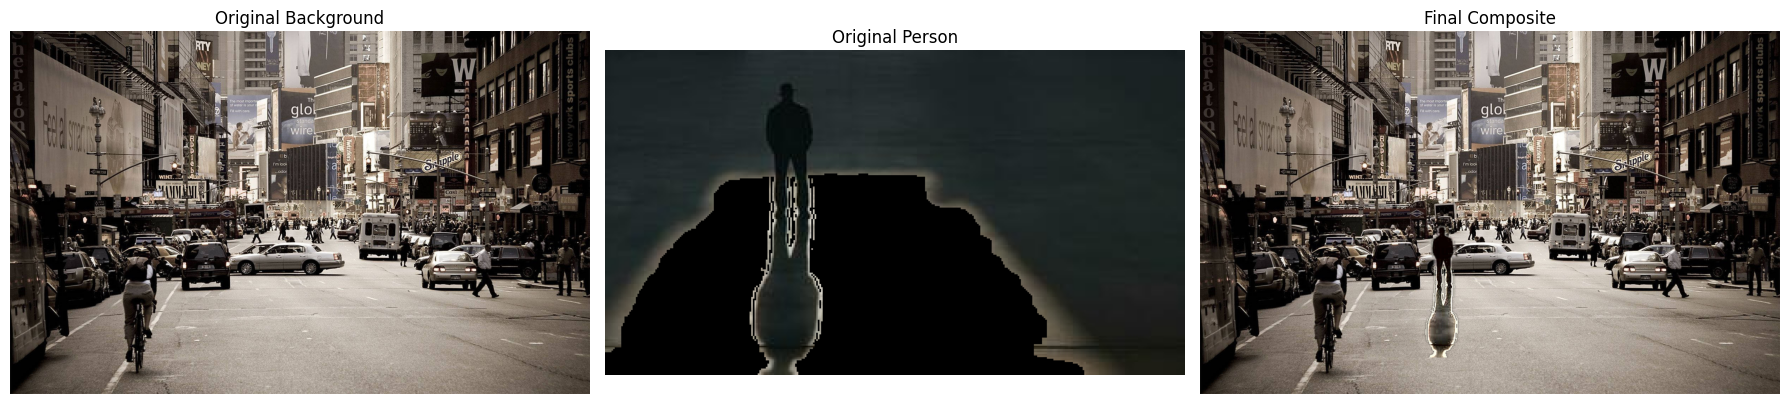

In [14]:
def refine_edges(image, mask, iterations=2):
    """
    Refine edges using guided filter
    """
    # Convert mask to float
    mask_float = mask.astype(float) / 255.0

    # Apply guided filter for edge refinement
    refined_mask = cv2.ximgproc.guidedFilter(image, mask_float, radius=5, eps=0.2)

    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)

    return (refined_mask * 255).astype(np.uint8)

def apply_atmospheric_perspective(image, depth_map, intensity=0.3):
    """
    Apply atmospheric perspective based on depth
    """
    # Normalize depth map
    depth_norm = depth_map.astype(float) / 255.0

    # Create haze effect
    haze_color = np.array([200, 200, 210])  # Slight blue tint

    # Apply haze based on depth
    result = image.copy().astype(float)
    for c in range(3):
        result[:,:,c] = result[:,:,c] * (1 - depth_norm * intensity) + \
                       haze_color[c] * depth_norm * intensity

    return np.clip(result, 0, 255).astype(np.uint8)

# Apply final refinements
try:
    # Try to refine edges if ximgproc is available
    refined_mask = refine_edges(final_result, combined_mask)
    print("Edge refinement applied successfully")
except:
    print("Edge refinement skipped (opencv-contrib-python not installed)")
    refined_mask = combined_mask

# Display comparison
display_multiple_images(
    [bg_img, person_with_shadow[:,:,:3], final_result],
    ["Original Background", "Original Person", "Final Composite"],
    cols=3, figsize=(18, 6)
)

## Save Final Result

In [15]:
# Save the final result
output_filename = "final_composite_result.jpg"
cv2.imwrite(output_filename, cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR))
print(f"Final result saved as: {output_filename}")

# Download the file in Colab
files.download(output_filename)

Final result saved as: final_composite_result.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

This notebook implements a complete pipeline for seamlessly integrating a person with shadow into a background scene:

1. **Person Extraction**: Removed background and preserved shadow
2. **Shadow Analysis**: Detected and classified shadows (hard/soft)
3. **Light Direction**: Estimated lighting in both images
4. **Color Matching**: Applied histogram matching and color transfer
5. **Shadow Transformation**: Adjusted shadow based on scene lighting
6. **Final Blending**: Seamlessly integrated person into scene with proper lighting and shadows

The algorithm considers:
- Light intensity and direction
- Shadow softness and opacity
- Color harmonization
- Edge feathering for natural blending
- Optimal placement and scaling